In [85]:
import numpy as np
import pandas as pd
import math
import os
from typing import List
import cv2

In [86]:
def calculate_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def analyze_image(image_path: str, crop_size: int = 200, calibration_mm_per_pixel: float = 0.00654):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape
    center_y, center_x = h // 2, w // 2
    zoomed_crop = gray[center_y - crop_size//2:center_y + crop_size//2,
                       center_x - crop_size//2:center_x + crop_size//2]

    edges = cv2.Canny(zoomed_crop, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=10, maxLineGap=5)

    if lines is None:
        return pd.DataFrame(), {}

    measurements = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length_px = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        width_px = abs(y2 - y1) if abs(y2 - y1) > 0 else 1
        angle = calculate_angle(x1, y1, x2, y2)
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        measurements.append({
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "length_px": length_px,
            "width_px": width_px,
            "length_mm": length_px * calibration_mm_per_pixel,
            "width_mm": width_px * calibration_mm_per_pixel,
            "angle": angle,
            "mid_x": mid_x,
            "mid_y": mid_y
        })

    df = pd.DataFrame(measurements)

    # Tightly filter horizontal and vertical lines
    horizontal_lines = df[(df['angle'].abs() < 5) | (df['angle'].abs() > 175)].sort_values(by='mid_y')
    vertical_lines = df[(df['angle'].between(85, 95))].sort_values(by='mid_x')

    gap_width_px = horizontal_lines['mid_y'].diff().dropna()
    gap_width_mm = gap_width_px * calibration_mm_per_pixel

    gap_length_px = vertical_lines['mid_x'].diff().dropna()
    gap_length_mm = gap_length_px * calibration_mm_per_pixel

    match = re.search(r"([0-9.]+)kv(AC|DC)", image_path, re.IGNORECASE)
    if match:
        voltage = float(match.group(1))
        voltage_type = match.group(2).upper()
    
    stats = {
        "image": os.path.basename(image_path),
        "avg_line_length_mm": df['length_mm'].mean(),
        "avg_line_width_mm": df['width_mm'].mean(),
        "avg_gap_length_mm": gap_length_mm.mean() if not gap_length_mm.empty else 0,
        "avg_gap_width_mm": gap_width_mm.mean() if not gap_width_mm.empty else 0,
        "total_lines": len(df),
        "horizontal_lines": len(horizontal_lines),
        "vertical_lines": len(vertical_lines),
        "voltage": voltage,
        "type": voltage_type
    }

    return df, stats

In [87]:
def analyze_multiple_images(image_paths: List[str], crop_size: int = 200, calibration_mm_per_pixel: float = 0.00654):
    all_stats = []
    all_dfs = []
    for path in image_paths:
        df, stats = analyze_image(path, crop_size, calibration_mm_per_pixel)
        if not df.empty:
            df['source_image'] = os.path.basename(path)
            all_dfs.append(df)
        all_stats.append(stats)
    
    df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
    df_stats = pd.DataFrame(all_stats)
    return df_all, df_stats

In [89]:
images = [
     "0.2kvDC.jpg",
     "0.4kVDC.jpg",
     "0.6kvDC.jpg",
     "0.8kvDC.jpg",
     "1kvDC.jpg",
     "0.5kVAC.jpg",
     "1kvAC.jpg",
     "2kvAC.jpg",
     "3kvAC.jpg",
    "0.1kvDC.jpg",
    "0.3kvDC.jpg",
    "0.5kvDC.jpg",
    "0.7kvDC.jpg",
    "0.9kvDC.jpg",
    "1.1kvAC.jpg",
    "1.3kvAC.jpg",
    "1.7kvAC.jpg",
    "1.9kvAC.jpg",
    "2.1kvAC.jpg",
    "2.3kvAC.jpg"
    ]

detailed_data, summary_stats = analyze_multiple_images(images)

In [90]:
summary_stats   
summary_stats.to_csv("New Updated Values.csv")

In [19]:
import re

def collect_image_paths_and_labels(root_dir):
    image_label_data = []

    for subdir, _, files in os.walk(root_dir):
        folder_name = os.path.basename(subdir)

        # Match folder name like "0.2kvDC", "1kvAC", etc.
        match = re.match(r"([0-9.]+)kv(AC|DC)", folder_name, re.IGNORECASE)
        if match:
            voltage = float(match.group(1))
            voltage_type = match.group(2).upper()

            # Sort files for consistent ordering
            valid_images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            valid_images.sort()

            for idx, file in enumerate(valid_images):
                full_path = os.path.join(subdir, file)
                synthetic_name = f"{match.group(1)}kv{voltage_type}_{idx+1:03d}"
                image_label_data.append({
                    "path": full_path,
                    "voltage": voltage,
                    "type": voltage_type,
                    "synthetic_name": synthetic_name
                })

    return image_label_data


In [101]:
def analyze_folder_dataset(image_info_list):
    all_stats = []
    for info in image_info_list:
        df, stats = analyze_image(info['path'])
        if stats:
            stats["image"] = info["synthetic_name"]
            stats["voltage"] = info["voltage"]
            stats["type"] = info["type"]
            all_stats.append(stats)

    return pd.DataFrame(all_stats)


In [102]:
image_info = collect_image_paths_and_labels("voltage_dataset/")
summary_stats_df = analyze_folder_dataset(image_info)

Separate Datasets for Test and Train

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier

# Prepare the training data
train_df = summary_stats.copy()
train_df["type"] = train_df["type"].map({"DC": 0, "AC": 1})

X_train = train_df.drop(columns=["voltage", "type", "image", 'total_lines', "horizontal_lines", "vertical_lines"])
y_train_reg = train_df["voltage"]
y_train_clf = train_df["type"]

# Feature selection using RandomForest feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_reg)
importances = rf.feature_importances_
important_features = [X_train.columns[i] for i in np.argsort(importances)[::-1] if importances[i] > 0.05]
X_train_selected = X_train[important_features]

# Scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

# Train regression model
xgb_reg = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42)
xgb_reg.fit(X_train_scaled, y_train_reg)

# Train classification model using ensemble
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('rf', clf1),
    ('xgb', clf2)
], voting='soft')
voting_clf.fit(X_train_scaled, y_train_clf)

# ------------------------
# Prepare and evaluate on test set
# ------------------------
test_df = summary_stats_df.copy()
test_df["type"] = test_df["type"].map({"DC": 0, "AC": 1})

X_test = test_df[important_features]
y_test_reg = test_df["voltage"]
y_test_clf = test_df["type"]
X_test_scaled = scaler.transform(X_test)

# Predictions
y_pred_test_reg = xgb_reg.predict(X_test_scaled)
y_pred_test_clf = voting_clf.predict(X_test_scaled)

# Evaluation
reg_mse = mean_squared_error(y_test_reg, y_pred_test_reg)
cls_acc = accuracy_score(y_test_clf, y_pred_test_clf)

# ------------------------
# Results
# ------------------------
print("Test Set Regression MSE:", reg_mse)
print("Test Set Classification Accuracy:", cls_acc)


Test Set Regression MSE: 1.6459281462355648
Test Set Classification Accuracy: 0.44802867383512546


In [ ]:
summary_stats_df.to_csv("Extended_Dataset.csv")

In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("Extended_Dataset.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
df["type"] = df["type"].map({"DC": 0, "AC": 1})

# Define features and targets
X = df.drop(columns=["voltage", "type", "image", "total_lines", "horizontal_lines", "vertical_lines"])
y_regression = df["voltage"]
y_classification = df["type"]

# Add engineered features
X["line_length_sq"] = X["avg_line_length_mm"] ** 2
X["gap_interaction"] = X["avg_gap_length_mm"] * X["avg_gap_width_mm"]

# Single train-test split
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_regression, y_classification, test_size=0.1, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduced parameter search space for efficiency
param_dist = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

# Optimized RandomizedSearchCV
xgb_reg_search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=1, verbosity=0),
    param_distributions=param_dist,
    scoring="neg_mean_squared_error",
    n_iter=5,  # fewer iterations
    cv=3,
    random_state=42,
    n_jobs=1  # limit to single thread
)

# Fit and evaluate
xgb_reg_search.fit(X_train_scaled, y_train_reg)
best_xgb_reg = xgb_reg_search.best_estimator_

# Predict and evaluate
y_pred_test_reg = best_xgb_reg.predict(X_test_scaled)
reg_mse = mean_squared_error(y_test_reg, y_pred_test_reg)

# Show results
comparison_df = pd.DataFrame({
    "True Voltage (kV)": y_test_reg.values,
    "Predicted Voltage (kV)": y_pred_test_reg,
    "Squared Error": (y_test_reg.values - y_pred_test_reg) ** 2
})

print(f"Mean Squared Error: {reg_mse:.6f}")
print(comparison_df.head(20))


param_dist_clf = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

xgb_clf_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=1, use_label_encoder=False, eval_metric="logloss"),
    param_distributions=param_dist_clf,
    scoring="accuracy",
    n_iter=5,
    cv=3,
    random_state=42,
    n_jobs=1
)
xgb_clf_search.fit(X_train_scaled, y_train_clf)
best_xgb_clf = xgb_clf_search.best_estimator_
y_pred_test_clf = best_xgb_clf.predict(X_test_scaled)

# Classification Metrics
acc = accuracy_score(y_test_clf, y_pred_test_clf)
prec = precision_score(y_test_clf, y_pred_test_clf)
rec = recall_score(y_test_clf, y_pred_test_clf)
f1 = f1_score(y_test_clf, y_pred_test_clf)

print(f"\n=== CLASSIFICATION RESULTS ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Mean Squared Error: 0.541683
    True Voltage (kV)  Predicted Voltage (kV)  Squared Error
0                 0.9                0.557633       0.117215
1                 2.0                0.448912       2.405874
2                 2.0                0.929018       1.147002
3                 1.7                1.622243       0.006046
4                 0.7                0.570294       0.016824
5                 2.3                2.178641       0.014728
6                 2.0                0.732593       1.606321
7                 1.0                1.137127       0.018804
8                 3.0                0.850093       4.622101
9                 2.0                0.830868       1.366870
10                2.0                0.619227       1.906535
11                1.7                1.608466       0.008378
12                2.3                1.926599       0.139429
13                0.7                0.840806       0.019826
14                0.1                0.522917       0.17

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src


=== CLASSIFICATION RESULTS ===
Accuracy:  0.7121
Precision: 0.7273
Recall:    0.7059
F1 Score:  0.7164


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src

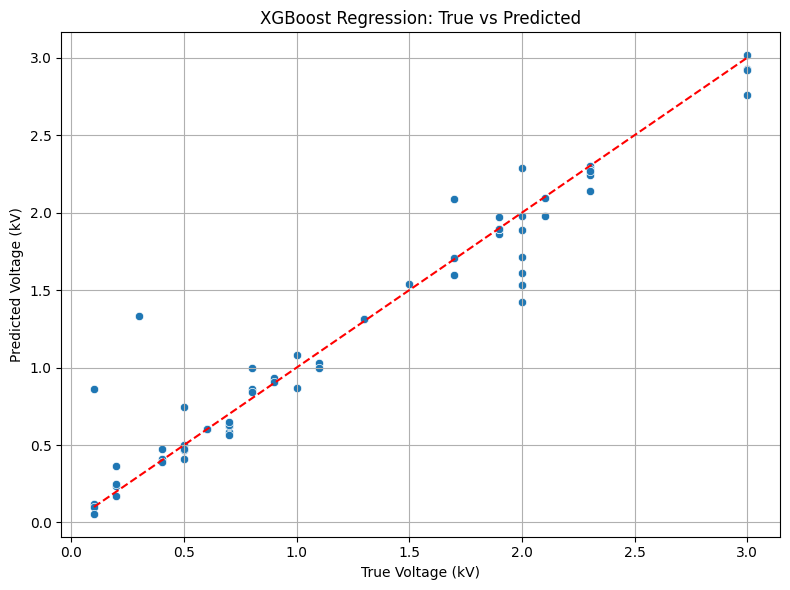

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# True vs Predicted scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_test_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("True Voltage (kV)")
plt.ylabel("Predicted Voltage (kV)")
plt.title("XGBoost Regression: True vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

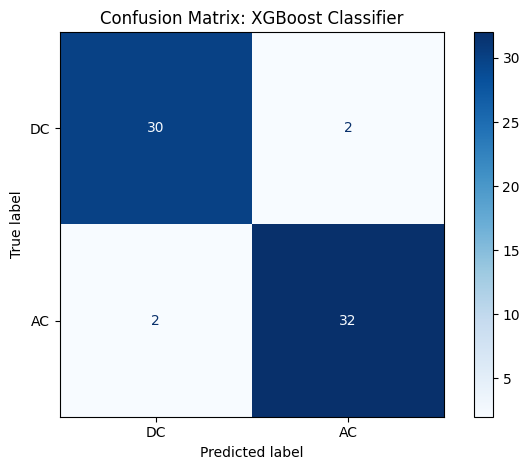

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_clf, y_pred_test_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["DC", "AC"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: XGBoost Classifier")
plt.tight_layout()
plt.show()


In [ ]:
results = pd.DataFrame({
    "Voltage Value": 
    "True Voltage Type": y_test_clf.map({0: "DC", 1: "AC"}).values,
    "Predicted Voltage Type": pd.Series(y_pred_test_clf).map({0: "DC", 1: "AC"}).values
})
results["Result"] = np.where(results["True Voltage Type"] == results["Predicted Voltage Type"], "✅ Correct", "❌ Incorrect")

In [154]:
results.head(10)

,True Voltage Type,Predicted Voltage Type,Result
0,DC,DC,✅ Correct
1,AC,DC,❌ Incorrect
2,AC,AC,✅ Correct
3,AC,AC,✅ Correct
4,DC,DC,✅ Correct
5,AC,AC,✅ Correct
6,AC,AC,✅ Correct
7,AC,AC,✅ Correct
8,AC,AC,✅ Correct
9,AC,AC,✅ Correct


In [168]:
folder_path = "CNT_0.1/"

# Step 1: Get all image paths in the folder
image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)
               if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif'))]

# Step 2: Run analysis
test_features, test_stats = analyze_multiple_images(image_paths)
test_df = pd.DataFrame(test_stats)

In [173]:
test_df

,image,avg_line_length_mm,avg_line_width_mm,avg_gap_length_mm,avg_gap_width_mm,total_lines,horizontal_lines,vertical_lines,voltage,type,line_length_sq,gap_interaction
0,0.9kvDC.jpg,0.187565,0.111588,0.066605,0.018146,609,72,20,0.9,0,0.035181,0.001209
1,0.1kvDC.jpg,0.156156,0.089834,0.113558,0.023896,466,53,12,0.1,0,0.024385,0.002714
2,0.7kvAC.jpg,0.123050,0.058248,0.177981,0.026755,171,45,8,0.7,1,0.015141,0.004762
3,0.3kvDC.jpg,0.231938,0.157554,0.051404,0.022326,595,59,26,0.3,0,0.053795,0.001148
4,0.5kvAC.jpg,0.230234,0.137870,0.066949,0.013015,605,101,20,0.5,1,0.053008,0.000871
5,0.1kVAC.jpg,0.151616,0.098773,0.245250,0.035243,418,37,6,0.1,1,0.022987,0.008643
6,0.7kvDC.jpg,0.160551,0.077282,0.214512,0.011163,475,117,6,0.7,0,0.025777,0.002395
7,0.9kvAC.jpg,0.230841,0.147958,0.055732,0.023065,579,57,24,0.9,1,0.053288,0.001285
8,1.3kvAC.jpg,0.204896,0.118043,0.074441,0.016186,608,81,18,1.3,1,0.041982,0.001205
9,1.1kvAC.jpg,0.204883,0.120669,0.091560,0.016602,601,79,15,1.1,1,0.041977,0.001520


In [ ]:
test_df["line_length_sq"] = test_df["avg_line_length_mm"] ** 2
test_df["gap_interaction"] = test_df["avg_gap_length_mm"] * test_df["avg_gap_width_mm"]
X_new = test_df.drop(columns=["voltage", "type", "image", "total_lines", "horizontal_lines", "vertical_lines"])

X_new_scaled = scaler.transform(X_new)  # Use the already-fitted scaler

# Run predictions using already-trained models
new_pred_voltage = best_xgb_reg.predict(X_new_scaled)
new_pred_type = best_xgb_clf.predict(X_new_scaled)

# Combine into new results DataFrame
new_results = X_new.copy()
new_results["predicted_voltage"] = new_pred_voltage
new_results["predicted_type"] = pd.Series(new_pred_type).map({0: "DC", 1: "AC"})

In [182]:
new_results

,avg_line_length_mm,avg_line_width_mm,avg_gap_length_mm,avg_gap_width_mm,line_length_sq,gap_interaction,predicted_voltage,predicted_type
0,0.187565,0.111588,0.066605,0.018146,0.035181,0.001209,1.500860,AC
1,0.156156,0.089834,0.113558,0.023896,0.024385,0.002714,2.173873,AC
2,0.123050,0.058248,0.177981,0.026755,0.015141,0.004762,2.136761,AC
3,0.231938,0.157554,0.051404,0.022326,0.053795,0.001148,0.769862,AC
4,0.230234,0.137870,0.066949,0.013015,0.053008,0.000871,1.680573,AC
5,0.151616,0.098773,0.245250,0.035243,0.022987,0.008643,2.112356,AC
6,0.160551,0.077282,0.214512,0.011163,0.025777,0.002395,2.229123,AC
7,0.230841,0.147958,0.055732,0.023065,0.053288,0.001285,0.667688,AC
8,0.204896,0.118043,0.074441,0.016186,0.041982,0.001205,1.506843,DC
9,0.204883,0.120669,0.091560,0.016602,0.041977,0.001520,1.612285,DC


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: type, dtype: float64

In [181]:
from sklearn.metrics import classification_report


y_true_voltage = test_df["voltage"]
y_true_type = test_df["type"]

# Regression metrics
rmse = mean_squared_error(y_true_voltage, new_pred_voltage, squared=False)

# Classification metrics
accuracy = accuracy_score(y_true_type, new_pred_type)
clf_report = classification_report(y_true_type, new_pred_type, target_names=["DC", "AC"], output_dict=True)

# Summary DataFrame
stats_df = pd.DataFrame({
    "RMSE (Voltage)": [rmse],
    "Accuracy (Type)": [accuracy],
    "Precision (DC)": [clf_report["DC"]["precision"]],
    "Recall (DC)": [clf_report["DC"]["recall"]],
    "Precision (AC)": [clf_report["AC"]["precision"]],
    "Recall (AC)": [clf_report["AC"]["recall"]]
})

print(stats_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.